In [1]:
import pandas as pd
import numpy as np
import string

from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as pp
from os import listdir
from numpy import array
from os.path import isfile, join
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

In [2]:
####---------------------------DATA MANIPULATION ---------------------------------####
#load the currencies files
path='data/'
CurrenciesFilesPath = ['data/'+f for f in listdir(path) if isfile(join(path, f))]
for file in CurrenciesFilesPath:
    print(file)

data/BCH-USD.csv
data/BTC-USD.csv
data/ETH-USD.csv
data/IOT-USD.csv
data/LTC-USD.csv
data/XMR-USD.csv
data/XRP-USD.csv


In [3]:
data=pd.read_csv(CurrenciesFilesPath[0], index_col='Date', parse_dates=['Date'], converters={'Close':np.float32})
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-09,2404.739990,2489.580078,2319.189941,2376.679932,2376.679932,118646869
2018-01-10,2376.679932,2944.889893,2291.939941,2856.929932,2856.929932,428980394
2018-01-11,2856.939941,2952.679932,2341.770020,2437.919922,2437.919922,370363445
2018-01-12,2437.919922,2628.149902,2372.669922,2596.199951,2596.199951,147982320
2018-01-13,2596.209961,2869.379883,2561.699951,2664.899902,2664.899902,183442789
...,...,...,...,...,...,...
2018-12-30,162.529999,164.830002,158.139999,163.220001,163.220001,9783009
2018-12-31,163.220001,163.649994,146.550003,149.229996,149.229996,9981144
2019-01-01,149.229996,166.399994,148.059998,165.020004,165.020004,12956870


In [4]:
data=data.drop(['Open','High','Low','Adj Close','Volume'],1)
data=data.loc[~data.index.duplicated(keep='first')]
data

,Close
Date,
2018-01-09,2376.679932
2018-01-10,2856.929932
2018-01-11,2437.919922
2018-01-12,2596.199951
2018-01-13,2664.899902
...,...
2018-12-30,163.220001
2018-12-31,149.229996
2019-01-01,165.020004


In [5]:
def split_sequence(sequence, n_steps):
    X, y= list(), list()
    for i in range(len(sequence)):
            #find the end of this pattern
            end_ix=i+n_steps
            #check if we are beyond the sequence
            if end_ix> len(sequence)-1:
                break
            #gather input and output parts of the pattern
            seq_x, seq_y= sequence[i:end_ix], sequence[end_ix]
            X.append(seq_x)
            y.append(seq_y)
    return array(X), array(y)           

In [6]:
temp=data.values.tolist()
data_list= list()
for x in temp:
    for y in x:
        data_list.append(y)

data_list

[2376.679931640625,
 2856.929931640625,
 2437.919921875,
 2596.199951171875,
 2664.89990234375,
 2530.2099609375,
 2394.050048828125,
 1761.6099853515625,
 1748.800048828125,
 1708.8699951171875,
 1756.719970703125,
 2024.3199462890625,
 1772.3699951171875,
 1606.050048828125,
 1614.4599609375,
 1653.4599609375,
 1632.1099853515625,
 1594.6700439453125,
 1632.0799560546875,
 1742.5400390625,
 1650.3599853515625,
 1462.989990234375,
 1487.1800537109375,
 1267.989990234375,
 1192.1300048828125,
 1273.0799560546875,
 1158.5699462890625,
 884.0,
 966.7899780273438,
 954.3400268554688,
 1280.550048828125,
 1299.969970703125,
 1240.6199951171875,
 1210.989990234375,
 1282.6300048828125,
 1220.8900146484375,
 1353.1800537109375,
 1359.469970703125,
 1530.43994140625,
 1543.2099609375,
 1453.3699951171875,
 1521.9200439453125,
 1393.77001953125,
 1287.06005859375,
 1210.0,
 1256.52001953125,
 1182.030029296875,
 1172.5799560546875,
 1244.4200439453125,
 1234.199951171875,
 1200.3299560546875,


In [7]:
n_steps=5
n_features=1
number_to_cutoff=int(round(0.15*len(data_list),0))
trainX, trainY=split_sequence(data_list[:-number_to_cutoff], n_steps)
testX, testY=split_sequence(data_list[number_to_cutoff:], n_steps)

In [8]:
########### VANILLA LSTM
# define model
LSTM_model = keras.Sequential()
LSTM_model._name="VanillaLSTM"
LSTM_model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
LSTM_model.add(Dense(1))
#LSTM_model.compile(optimizer='adam', loss='mse')

In [9]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))
valX = testX.reshape(-1, n_steps, n_features)

In [10]:
############# STACKED LSTM
Std_LSTM_model = Sequential()
Std_LSTM_model._name="Std_LSTM"
Std_LSTM_model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
Std_LSTM_model.add(LSTM(50, activation='relu'))
Std_LSTM_model.add(Dense(1))
#Std_LSTM_model.compile(optimizer='adam', loss='mse')

In [11]:
############# Bidirectional LSTM
# define model
bid_LSTM_model = Sequential()
bid_LSTM_model._name="Bidirect_LSTM"
bid_LSTM_model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
bid_LSTM_model.add(Dense(1))
#bid_LSTM_model.compile(optimizer='adam', loss='mse')

In [12]:
############ Convolutional neural network/CNN LSTM 
#A CNN model can be used in a hybrid model with an LSTM backend where the CNN is used to interpret subsequences 
#of input that together are provided as a sequence to an LSTM model to interpret. This hybrid model is called a CNN-LSTM.

#need to reshape the data!
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_seq = 1
print('Shape of X: ',trainX.shape)
print('Shape of Y: ',trainY.shape)
trainX_CNN = trainX.reshape((trainX.shape[0], n_seq, n_steps, n_features)) #the multiplication must add up to the total of items
valX_CNN=testX.reshape((trainX.shape[0], n_seq, n_steps, n_features))

Shape of X:  (300, 5)
Shape of Y:  (300,)


In [13]:
trainX_CNN.shape

(300, 1, 5, 1)

In [14]:
for value in trainX_CNN:
    print(value[-1][-1][0])

2664.89990234375
2530.2099609375
2394.050048828125
1761.6099853515625
1748.800048828125
1708.8699951171875
1756.719970703125
2024.3199462890625
1772.3699951171875
1606.050048828125
1614.4599609375
1653.4599609375
1632.1099853515625
1594.6700439453125
1632.0799560546875
1742.5400390625
1650.3599853515625
1462.989990234375
1487.1800537109375
1267.989990234375
1192.1300048828125
1273.0799560546875
1158.5699462890625
884.0
966.7899780273438
954.3400268554688
1280.550048828125
1299.969970703125
1240.6199951171875
1210.989990234375
1282.6300048828125
1220.8900146484375
1353.1800537109375
1359.469970703125
1530.43994140625
1543.2099609375
1453.3699951171875
1521.9200439453125
1393.77001953125
1287.06005859375
1210.0
1256.52001953125
1182.030029296875
1172.5799560546875
1244.4200439453125
1234.199951171875
1200.3299560546875
1285.010009765625
1276.6400146484375
1272.260009765625
1285.239990234375
1266.9300537109375
1207.4300537109375
1095.9100341796875
1033.9599609375
1065.68994140625
1003.780

In [15]:
CNN_model=Sequential()
CNN_model._name="CNN_Model"
CNN_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
CNN_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
CNN_model.add(TimeDistributed(Flatten()))
CNN_model.add(LSTM(50, activation='relu'))
CNN_model.add(Dense(1))
#CNN_model.compile(optimizer='adam', loss='mse')

In [16]:
############ ConvLSTM
trainX_Conv = trainX.reshape((trainX.shape[0], n_seq, 1, n_steps, n_features))
valX_Conv=testX.reshape(testX.shape[0], n_seq, 1, n_steps, n_features)

In [17]:
Conv_model=Sequential()
Conv_model._name="Conv_LSTM_model"
Conv_model.add(ConvLSTM2D(filters=64, kernel_size=(1,2),activation='relu', input_shape=(n_seq,1,n_steps,n_features)))
Conv_model.add(Flatten())
Conv_model.add(Dense(1))
#Conv_model.compile(optimizer='adam',loss='mse')

In [18]:
Models=[LSTM_model, Std_LSTM_model, bid_LSTM_model, CNN_model, Conv_model]
TrainSets=[X,X,X, trainX_CNN, trainX_Conv]
TestSets=[valX, valX, valX, valX_CNN,valX_Conv]

In [19]:
#### FIND LEARNING RATE!!!!!!!!!!!!! #####
######################3################
# find best learning rate for the models!
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8*10**(epoch/20))
optimizer= tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
history=[]
for i, model in enumerate(Models):
    print(model.summary())
    trainX=TrainSets[i]
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
    history.append(model.fit(trainX, trainY, epochs=100, callbacks=[lr_schedule]))
#Conv_model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
#history= Conv_model.fit(trainX_Conv, trainY, epochs=100, callbacks=[lr_schedule])

SyntaxError: invalid syntax (<ipython-input-19-ec3eee6ada81>, line 2)

In [20]:
for i, his in enumerate(history):
    pp.figure()
    pp.semilogx(his.history["lr"], his.history["loss"])
    pp.title(Models[i].name)
    pp.show
#plt.axis([1e-8, 1e-4, 0, 60])

NameError: name 'history' is not defined

In [21]:
lr_rates=[1e-5,1e-6, 2e-6,1e-5,2e-5]
tf.keras.backend.clear_session()

In [22]:
history=[]
# clear session does not seem to work properly - run it without having run the lr scheduler
for i, model in enumerate(Models):
    print(model.summary())
    print("Learning rate:", lr_rates[i])
    trainX=TrainSets[i]
    optimizer = tf.keras.optimizers.SGD(lr=lr_rates[i], momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
    history.append(model.fit(trainX, trainY, epochs=500))

Model: "VanillaLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
None
Learning rate: 1e-05
Epoch 1/500
10/10 [==============================] - 0s 2ms/step - loss: 513.9919 - mae: 514.4919
Epoch 2/500
10/10 [==============================] - 0s 2ms/step - loss: 219.3704 - mae: 219.8701
Epoch 3/500
10/10 [==============================] - 0s 2ms/step - loss: 153.3263 - mae: 153.8263
Epoch 4/500
10/10 [==============================] - 0s 2ms/step - loss: 105.3842 - mae: 105.8807
Epoch 5/500
10/10 [==============================] - 0s 2ms/step - loss: 100.9097 - mae: 101.40

Epoch 162/500
10/10 [==============================] - 0s 2ms/step - loss: 46.2928 - mae: 46.7870
Epoch 163/500
10/10 [==============================] - 0s 2ms/step - loss: 48.3471 - mae: 48.8407
Epoch 164/500
10/10 [==============================] - 0s 2ms/step - loss: 50.3243 - mae: 50.8233
Epoch 165/500
10/10 [==============================] - 0s 2ms/step - loss: 49.4031 - mae: 49.9007
Epoch 166/500
10/10 [==============================] - 0s 2ms/step - loss: 47.5330 - mae: 48.0302
Epoch 167/500
10/10 [==============================] - 0s 2ms/step - loss: 46.0855 - mae: 46.5795
Epoch 168/500
10/10 [==============================] - 0s 2ms/step - loss: 46.6422 - mae: 47.1405
Epoch 169/500
10/10 [==============================] - 0s 2ms/step - loss: 46.4409 - mae: 46.9377
Epoch 170/500
10/10 [==============================] - 0s 2ms/step - loss: 48.7959 - mae: 49.2934
Epoch 171/500
10/10 [==============================] - 0s 2ms/step - loss: 48.9795 - mae: 49.4763
Epoch 172/500
10/10 

10/10 [==============================] - 0s 2ms/step - loss: 47.1267 - mae: 47.6263
Epoch 329/500
10/10 [==============================] - 0s 2ms/step - loss: 48.5805 - mae: 49.0795
Epoch 330/500
10/10 [==============================] - 0s 2ms/step - loss: 47.8687 - mae: 48.3669
Epoch 331/500
10/10 [==============================] - 0s 2ms/step - loss: 45.9911 - mae: 46.4877
Epoch 332/500
10/10 [==============================] - 0s 2ms/step - loss: 46.2208 - mae: 46.7178
Epoch 333/500
10/10 [==============================] - 0s 2ms/step - loss: 46.6198 - mae: 47.1185
Epoch 334/500
10/10 [==============================] - 0s 2ms/step - loss: 46.1895 - mae: 46.6883
Epoch 335/500
10/10 [==============================] - 0s 2ms/step - loss: 45.9204 - mae: 46.4181
Epoch 336/500
10/10 [==============================] - 0s 2ms/step - loss: 46.2400 - mae: 46.7291
Epoch 337/500
10/10 [==============================] - 0s 2ms/step - loss: 52.1899 - mae: 52.6874
Epoch 338/500
10/10 [=============

10/10 [==============================] - 0s 2ms/step - loss: 47.0334 - mae: 47.5252
Epoch 495/500
10/10 [==============================] - 0s 2ms/step - loss: 51.5861 - mae: 52.0816
Epoch 496/500
10/10 [==============================] - 0s 2ms/step - loss: 51.3862 - mae: 51.8835
Epoch 497/500
10/10 [==============================] - 0s 2ms/step - loss: 46.0321 - mae: 46.5296
Epoch 498/500
10/10 [==============================] - 0s 2ms/step - loss: 46.2603 - mae: 46.7559
Epoch 499/500
10/10 [==============================] - 0s 2ms/step - loss: 45.7419 - mae: 46.2403
Epoch 500/500
10/10 [==============================] - 0s 2ms/step - loss: 47.6838 - mae: 48.1795
Model: "Std_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 50)             10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)       

Epoch 154/500
10/10 [==============================] - 0s 3ms/step - loss: 76.6432 - mae: 77.1405
Epoch 155/500
10/10 [==============================] - 0s 3ms/step - loss: 76.1656 - mae: 76.6638
Epoch 156/500
10/10 [==============================] - 0s 3ms/step - loss: 76.3035 - mae: 76.8008
Epoch 157/500
10/10 [==============================] - 0s 3ms/step - loss: 76.3418 - mae: 76.8405
Epoch 158/500
10/10 [==============================] - 0s 3ms/step - loss: 75.4757 - mae: 75.9691
Epoch 159/500
10/10 [==============================] - 0s 3ms/step - loss: 76.9850 - mae: 77.4827
Epoch 160/500
10/10 [==============================] - 0s 3ms/step - loss: 76.9582 - mae: 77.4580
Epoch 161/500
10/10 [==============================] - 0s 3ms/step - loss: 85.6626 - mae: 86.1606
Epoch 162/500
10/10 [==============================] - 0s 3ms/step - loss: 81.8450 - mae: 82.3394
Epoch 163/500
10/10 [==============================] - 0s 3ms/step - loss: 75.6573 - mae: 76.1542
Epoch 164/500
10/10 

10/10 [==============================] - 0s 3ms/step - loss: 65.3683 - mae: 65.8673
Epoch 321/500
10/10 [==============================] - 0s 3ms/step - loss: 58.3339 - mae: 58.8334
Epoch 322/500
10/10 [==============================] - 0s 3ms/step - loss: 57.1636 - mae: 57.6608
Epoch 323/500
10/10 [==============================] - 0s 3ms/step - loss: 61.2351 - mae: 61.7286
Epoch 324/500
10/10 [==============================] - 0s 3ms/step - loss: 59.5012 - mae: 59.9995
Epoch 325/500
10/10 [==============================] - 0s 3ms/step - loss: 56.1710 - mae: 56.6662
Epoch 326/500
10/10 [==============================] - 0s 3ms/step - loss: 54.4790 - mae: 54.9768
Epoch 327/500
10/10 [==============================] - 0s 3ms/step - loss: 54.1178 - mae: 54.6126
Epoch 328/500
10/10 [==============================] - 0s 3ms/step - loss: 54.0937 - mae: 54.5931
Epoch 329/500
10/10 [==============================] - 0s 3ms/step - loss: 56.9407 - mae: 57.4395
Epoch 330/500
10/10 [=============

10/10 [==============================] - 0s 3ms/step - loss: 46.7219 - mae: 47.2188
Epoch 487/500
10/10 [==============================] - 0s 3ms/step - loss: 48.3207 - mae: 48.8159
Epoch 488/500
10/10 [==============================] - 0s 3ms/step - loss: 49.8162 - mae: 50.3099
Epoch 489/500
10/10 [==============================] - 0s 3ms/step - loss: 47.2417 - mae: 47.7338
Epoch 490/500
10/10 [==============================] - 0s 3ms/step - loss: 46.8245 - mae: 47.3220
Epoch 491/500
10/10 [==============================] - 0s 3ms/step - loss: 46.3478 - mae: 46.8450
Epoch 492/500
10/10 [==============================] - 0s 3ms/step - loss: 47.0768 - mae: 47.5724
Epoch 493/500
10/10 [==============================] - 0s 3ms/step - loss: 46.6530 - mae: 47.1506
Epoch 494/500
10/10 [==============================] - 0s 3ms/step - loss: 47.0468 - mae: 47.5403
Epoch 495/500
10/10 [==============================] - 0s 3ms/step - loss: 51.3189 - mae: 51.8119
Epoch 496/500
10/10 [=============

10/10 [==============================] - 0s 2ms/step - loss: 54.3753 - mae: 54.8663
Epoch 148/500
10/10 [==============================] - 0s 2ms/step - loss: 59.9394 - mae: 60.4391
Epoch 149/500
10/10 [==============================] - 0s 2ms/step - loss: 58.7553 - mae: 59.2520
Epoch 150/500
10/10 [==============================] - 0s 2ms/step - loss: 55.3212 - mae: 55.8106
Epoch 151/500
10/10 [==============================] - 0s 2ms/step - loss: 55.3492 - mae: 55.8480
Epoch 152/500
10/10 [==============================] - 0s 2ms/step - loss: 53.8403 - mae: 54.3359
Epoch 153/500
10/10 [==============================] - 0s 2ms/step - loss: 53.6642 - mae: 54.1620
Epoch 154/500
10/10 [==============================] - 0s 2ms/step - loss: 62.9268 - mae: 63.4251
Epoch 155/500
10/10 [==============================] - 0s 2ms/step - loss: 59.0282 - mae: 59.5273
Epoch 156/500
10/10 [==============================] - 0s 2ms/step - loss: 54.6900 - mae: 55.1836
Epoch 157/500
10/10 [=============

10/10 [==============================] - 0s 2ms/step - loss: 51.9488 - mae: 52.4468
Epoch 314/500
10/10 [==============================] - 0s 2ms/step - loss: 49.2352 - mae: 49.7264
Epoch 315/500
10/10 [==============================] - 0s 2ms/step - loss: 49.9566 - mae: 50.4525
Epoch 316/500
10/10 [==============================] - 0s 2ms/step - loss: 48.7027 - mae: 49.1986
Epoch 317/500
10/10 [==============================] - 0s 2ms/step - loss: 48.1195 - mae: 48.6145
Epoch 318/500
10/10 [==============================] - 0s 2ms/step - loss: 49.6692 - mae: 50.1673
Epoch 319/500
10/10 [==============================] - 0s 2ms/step - loss: 51.8154 - mae: 52.3138
Epoch 320/500
10/10 [==============================] - 0s 2ms/step - loss: 50.3916 - mae: 50.8884
Epoch 321/500
10/10 [==============================] - 0s 2ms/step - loss: 54.8670 - mae: 55.3657
Epoch 322/500
10/10 [==============================] - 0s 2ms/step - loss: 49.5116 - mae: 50.0071
Epoch 323/500
10/10 [=============

10/10 [==============================] - 0s 2ms/step - loss: 48.1215 - mae: 48.6187
Epoch 480/500
10/10 [==============================] - 0s 2ms/step - loss: 47.6640 - mae: 48.1591
Epoch 481/500
10/10 [==============================] - 0s 2ms/step - loss: 48.1947 - mae: 48.6914
Epoch 482/500
10/10 [==============================] - 0s 2ms/step - loss: 49.5365 - mae: 50.0338
Epoch 483/500
10/10 [==============================] - 0s 2ms/step - loss: 47.7350 - mae: 48.2330
Epoch 484/500
10/10 [==============================] - 0s 2ms/step - loss: 48.3112 - mae: 48.8083
Epoch 485/500
10/10 [==============================] - 0s 2ms/step - loss: 47.8489 - mae: 48.3460
Epoch 486/500
10/10 [==============================] - 0s 2ms/step - loss: 46.2626 - mae: 46.7583
Epoch 487/500
10/10 [==============================] - 0s 2ms/step - loss: 46.5620 - mae: 47.0607
Epoch 488/500
10/10 [==============================] - 0s 2ms/step - loss: 47.6847 - mae: 48.1834
Epoch 489/500
10/10 [=============

10/10 [==============================] - 0s 1ms/step - loss: 79.7687 - mae: 80.2671
Epoch 136/500
10/10 [==============================] - 0s 1ms/step - loss: 75.3598 - mae: 75.8578
Epoch 137/500
10/10 [==============================] - 0s 898us/step - loss: 86.3446 - mae: 86.8445
Epoch 138/500
10/10 [==============================] - 0s 997us/step - loss: 80.7115 - mae: 81.2101
Epoch 139/500
10/10 [==============================] - 0s 997us/step - loss: 75.3479 - mae: 75.8443
Epoch 140/500
10/10 [==============================] - 0s 1ms/step - loss: 86.6537 - mae: 87.1527
Epoch 141/500
10/10 [==============================] - 0s 997us/step - loss: 78.1383 - mae: 78.6355
Epoch 142/500
10/10 [==============================] - 0s 898us/step - loss: 78.6133 - mae: 79.1113
Epoch 143/500
10/10 [==============================] - 0s 997us/step - loss: 77.6150 - mae: 78.1124
Epoch 144/500
10/10 [==============================] - 0s 1ms/step - loss: 77.8442 - mae: 78.3402
Epoch 145/500
10/10 [=

10/10 [==============================] - 0s 1ms/step - loss: 76.5398 - mae: 77.0356
Epoch 219/500
10/10 [==============================] - 0s 898us/step - loss: 75.9410 - mae: 76.4367
Epoch 220/500
10/10 [==============================] - 0s 997us/step - loss: 77.1401 - mae: 77.6355
Epoch 221/500
10/10 [==============================] - 0s 1ms/step - loss: 76.8416 - mae: 77.3391
Epoch 222/500
10/10 [==============================] - 0s 1ms/step - loss: 80.2970 - mae: 80.7956
Epoch 223/500
10/10 [==============================] - 0s 1ms/step - loss: 75.6717 - mae: 76.1700
Epoch 224/500
10/10 [==============================] - 0s 997us/step - loss: 75.4499 - mae: 75.9460
Epoch 225/500
10/10 [==============================] - 0s 898us/step - loss: 76.3787 - mae: 76.8783
Epoch 226/500
10/10 [==============================] - 0s 997us/step - loss: 76.0474 - mae: 76.5433
Epoch 227/500
10/10 [==============================] - 0s 1ms/step - loss: 79.4832 - mae: 79.9831
Epoch 228/500
10/10 [===

Epoch 301/500
10/10 [==============================] - 0s 1ms/step - loss: 77.3101 - mae: 77.8068
Epoch 302/500
10/10 [==============================] - 0s 897us/step - loss: 76.7208 - mae: 77.2181
Epoch 303/500
10/10 [==============================] - 0s 997us/step - loss: 75.9174 - mae: 76.4164
Epoch 304/500
10/10 [==============================] - 0s 1ms/step - loss: 76.0563 - mae: 76.5538
Epoch 305/500
10/10 [==============================] - 0s 1ms/step - loss: 75.5604 - mae: 76.0585
Epoch 306/500
10/10 [==============================] - 0s 1ms/step - loss: 75.8073 - mae: 76.3055
Epoch 307/500
10/10 [==============================] - 0s 997us/step - loss: 77.5165 - mae: 78.0161
Epoch 308/500
10/10 [==============================] - 0s 997us/step - loss: 76.4497 - mae: 76.9493
Epoch 309/500
10/10 [==============================] - 0s 1ms/step - loss: 75.8456 - mae: 76.3427
Epoch 310/500
10/10 [==============================] - 0s 1ms/step - loss: 81.3767 - mae: 81.8739
Epoch 311/50

10/10 [==============================] - 0s 997us/step - loss: 77.0659 - mae: 77.5649
Epoch 467/500
10/10 [==============================] - 0s 997us/step - loss: 78.4240 - mae: 78.9232
Epoch 468/500
10/10 [==============================] - 0s 1ms/step - loss: 76.8941 - mae: 77.3934
Epoch 469/500
10/10 [==============================] - 0s 1ms/step - loss: 77.0899 - mae: 77.5896
Epoch 470/500
10/10 [==============================] - 0s 1ms/step - loss: 75.7586 - mae: 76.2576
Epoch 471/500
10/10 [==============================] - 0s 898us/step - loss: 78.1961 - mae: 78.6954
Epoch 472/500
10/10 [==============================] - 0s 898us/step - loss: 79.9308 - mae: 80.4268
Epoch 473/500
10/10 [==============================] - 0s 1ms/step - loss: 76.5181 - mae: 77.0126
Epoch 474/500
10/10 [==============================] - 0s 1ms/step - loss: 75.5944 - mae: 76.0903
Epoch 475/500
10/10 [==============================] - 0s 1ms/step - loss: 75.2347 - mae: 75.7342
Epoch 476/500
10/10 [=====

Epoch 42/500
10/10 [==============================] - 0s 2ms/step - loss: 47.3406 - mae: 47.8364
Epoch 43/500
10/10 [==============================] - 0s 2ms/step - loss: 58.3538 - mae: 58.8515
Epoch 44/500
10/10 [==============================] - 0s 2ms/step - loss: 81.6964 - mae: 82.1962
Epoch 45/500
10/10 [==============================] - 0s 2ms/step - loss: 66.8961 - mae: 67.3927
Epoch 46/500
10/10 [==============================] - 0s 2ms/step - loss: 57.8342 - mae: 58.3331
Epoch 47/500
10/10 [==============================] - 0s 2ms/step - loss: 70.9791 - mae: 71.4783
Epoch 48/500
10/10 [==============================] - 0s 2ms/step - loss: 57.0930 - mae: 57.5927
Epoch 49/500
10/10 [==============================] - 0s 2ms/step - loss: 66.2243 - mae: 66.7238
Epoch 50/500
10/10 [==============================] - 0s 2ms/step - loss: 84.6700 - mae: 85.1690
Epoch 51/500
10/10 [==============================] - 0s 2ms/step - loss: 86.8877 - mae: 87.3849
Epoch 52/500
10/10 [==========

10/10 [==============================] - 0s 2ms/step - loss: 53.4299 - mae: 53.9283
Epoch 210/500
10/10 [==============================] - 0s 2ms/step - loss: 51.2626 - mae: 51.7596
Epoch 211/500
10/10 [==============================] - 0s 2ms/step - loss: 52.2159 - mae: 52.7148
Epoch 212/500
10/10 [==============================] - 0s 2ms/step - loss: 55.5580 - mae: 56.0560
Epoch 213/500
10/10 [==============================] - 0s 2ms/step - loss: 50.2553 - mae: 50.7530
Epoch 214/500
10/10 [==============================] - 0s 2ms/step - loss: 47.0878 - mae: 47.5794
Epoch 215/500
10/10 [==============================] - 0s 2ms/step - loss: 53.2744 - mae: 53.7721
Epoch 216/500
10/10 [==============================] - 0s 2ms/step - loss: 57.6029 - mae: 58.0983
Epoch 217/500
10/10 [==============================] - 0s 2ms/step - loss: 46.9237 - mae: 47.4211
Epoch 218/500
10/10 [==============================] - 0s 2ms/step - loss: 70.2521 - mae: 70.7487
Epoch 219/500
10/10 [=============

10/10 [==============================] - 0s 2ms/step - loss: 48.5200 - mae: 49.0176
Epoch 376/500
10/10 [==============================] - 0s 2ms/step - loss: 46.9726 - mae: 47.4698
Epoch 377/500
10/10 [==============================] - 0s 2ms/step - loss: 51.9510 - mae: 52.4472
Epoch 378/500
10/10 [==============================] - 0s 2ms/step - loss: 47.9411 - mae: 48.4286
Epoch 379/500
10/10 [==============================] - 0s 2ms/step - loss: 58.6460 - mae: 59.1415
Epoch 380/500
10/10 [==============================] - 0s 2ms/step - loss: 53.1904 - mae: 53.6904
Epoch 381/500
10/10 [==============================] - 0s 2ms/step - loss: 57.7683 - mae: 58.2671
Epoch 382/500
10/10 [==============================] - 0s 2ms/step - loss: 74.6356 - mae: 75.1335
Epoch 383/500
10/10 [==============================] - 0s 2ms/step - loss: 70.2704 - mae: 70.7678
Epoch 384/500
10/10 [==============================] - 0s 2ms/step - loss: 47.5174 - mae: 48.0164
Epoch 385/500
10/10 [=============

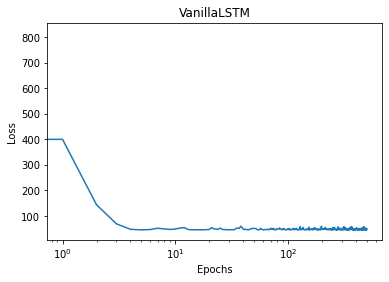

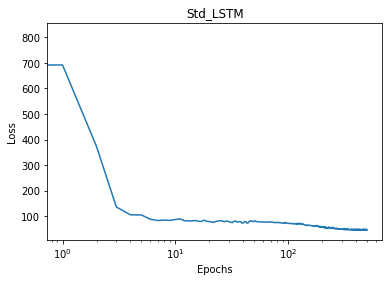

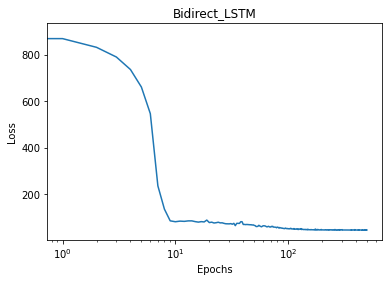

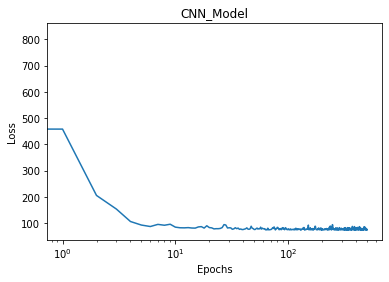

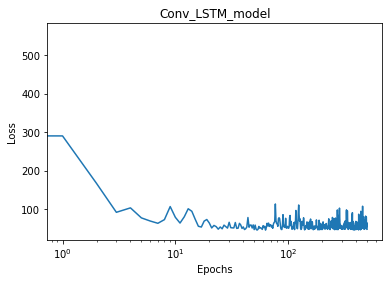

In [20]:
for i, his in enumerate(history):
    pp.figure()
    loss= his.history['loss']
    epochs=range(len(loss))
    pp.semilogx(epochs, loss)
    pp.xlabel("Epochs")
    pp.ylabel("Loss")
    pp.title(Models[i].name)
    pp.show

In [50]:
yhat=Models[-1].predict(TestSets[-1])
correct_incr_pred=0
incorrect_incr_pred=0

for i, testvalue in enumerate(TestSets[-1]):
    if model.name =="CNN_Model" or model.name =="Conv_LSTM_model": #since the format of the data is different
            pred_incr=temp[j]-testvalue[-1][-1][0]
            act_incr=testY[j]-testvalue[-1][-1][0]
    else:
            pred_incr=temp[j]-testvalue[-1]
            act_incr=testY[j]-testvalue[-1]
    if (pred_incr>0 and act_incr>0) or (pred_incr<0 and act_incr<0):
        correct_incr_pred=correct_incr_pred+1
        print("Increase correctly predicted")
    else:
        incorrect_incr_pred=incorrect_incr_pred+1
        print("Increase NOT correctly predicted")
    print("x value:", testvalue, " next predicted value:", yhat[i], ",it should have been", TestSets[0][i+1][-1], " or", testY[i])

Increase correctly predicted
x value: [[[[1285.23999023]
   [1266.93005371]
   [1207.43005371]
   [1095.91003418]
   [1033.95996094]]]]  next predicted value: [1001.0436] ,it should have been [1065.68994141]  or 1065.68994140625
Increase correctly predicted
x value: [[[[1266.93005371]
   [1207.43005371]
   [1095.91003418]
   [1033.95996094]
   [1065.68994141]]]]  next predicted value: [1029.7517] ,it should have been [1003.7800293]  or 1003.780029296875
Increase correctly predicted
x value: [[[[1207.43005371]
   [1095.91003418]
   [1033.95996094]
   [1065.68994141]
   [1003.7800293 ]]]]  next predicted value: [975.50244] ,it should have been [1138.83996582]  or 1138.8399658203125
Increase correctly predicted
x value: [[[[1095.91003418]
   [1033.95996094]
   [1065.68994141]
   [1003.7800293 ]
   [1138.83996582]]]]  next predicted value: [1109.5139] ,it should have been [1051.06005859]  or 1051.06005859375
Increase correctly predicted
x value: [[[[1033.95996094]
   [1065.68994141]
   [10

   [463.72000122]]]]  next predicted value: [448.1205] ,it should have been [447.5]  or 447.5
Increase correctly predicted
x value: [[[[466.54000854]
   [439.8999939 ]
   [431.72000122]
   [463.72000122]
   [447.5       ]]]]  next predicted value: [434.10977] ,it should have been [448.8999939]  or 448.8999938964844
Increase correctly predicted
x value: [[[[439.8999939 ]
   [431.72000122]
   [463.72000122]
   [447.5       ]
   [448.8999939 ]]]]  next predicted value: [437.65094] ,it should have been [450.45999146]  or 450.4599914550781
Increase correctly predicted
x value: [[[[431.72000122]
   [463.72000122]
   [447.5       ]
   [448.8999939 ]
   [450.45999146]]]]  next predicted value: [432.6891] ,it should have been [417.54998779]  or 417.54998779296875
Increase correctly predicted
x value: [[[[463.72000122]
   [447.5       ]
   [448.8999939 ]
   [450.45999146]
   [417.54998779]]]]  next predicted value: [405.7227] ,it should have been [432.69000244]  or 432.69000244140625
Increase co

IndexError: index 301 is out of bounds for axis 0 with size 301

In [36]:
print("total correctly predicted:", correct_incr_pred, "Incorrect:", incorrect_incr_pred, " Precentage:", (correct_incr_pred)/(correct_incr_pred+incorrect_incr_pred)*100)

totall correctly predicted: 167 Incorrect: 134  Precentage: 55.48172757475083


In [45]:
yhat=[]
for i, model in enumerate(Models):
    temp=model.predict(TestSets[i])
    yhat=[yhat, temp]
    correct_incr_pred=0
    incorrect_incr_pred=0
    
    for j, testvalue in enumerate(TestSets[i]):
        if model.name =="CNN_Model" or model.name =="Conv_LSTM_model": #since the format of the data is different
            pred_incr=temp[j]-testvalue[-1][-1][0]
            act_incr=testY[j]-testvalue[-1][-1][0]
        else:
            pred_incr=temp[j]-testvalue[-1]
            act_incr=testY[j]-testvalue[-1]
        if (pred_incr>0 and act_incr>0) or (pred_incr<0 and act_incr<0):
            correct_incr_pred=correct_incr_pred+1
        else:
            incorrect_incr_pred=incorrect_incr_pred+1
    print("For model ", model.name, "-- total correctly predicted:", correct_incr_pred, "Incorrect:", incorrect_incr_pred, " Precentage:", (correct_incr_pred)/(correct_incr_pred+incorrect_incr_pred)*100, "%")
    

For model  VanillaLSTM -- total correctly predicted: 167 Incorrect: 134  Precentage: 55.48172757475083 %
For model  Std_LSTM -- total correctly predicted: 145 Incorrect: 156  Precentage: 48.17275747508305 %
For model  Bidirect_LSTM -- total correctly predicted: 167 Incorrect: 134  Precentage: 55.48172757475083 %
For model  CNN_Model -- total correctly predicted: 174 Incorrect: 127  Precentage: 57.80730897009967 %
For model  Conv_LSTM_model -- total correctly predicted: 262 Incorrect: 39  Precentage: 87.04318936877077 %
